# Stance Propagation using Network Clustering

### Code by Giordano Paoletti

This method is used in an upcoming paper. For a pre-print, contact yelena.mejova@gmail.com

In this notebook we implement the assignment of scores concerning vaccination: pro-vaccination, anti-vaccination, or other. Originally, data is collected from Twitter. The tweets are used to build a retweet network (where the source retweets the target user). We have already sampled this network and labeled a selection of tweets for the vaccination stance.

**Input**

folder: `/data/`
- Edgelist folder+`BE_nl_fr_de_period4_RT_edges.csv.gz`
- Manually annotated tweets: folder+`annotated_tweets.csv`
- Tweets in the RT-Network: folder+`BE_nl_fr_de_period4.tsv.gz` 

**Summary of steps**

For i=1 to 100:
1. perturb network (giving importance to weight)
2. indentify communities in RT-network (negative eigenvalues)
3. use labeled tweets to assign labels to users using this clustering
     $$
     \sigma^{anti}_i=\frac{\frac{N_{anti}-N_{pro}}{N_{anti}+N_{pro}+N_{neutral}}+1}{2}
     $$
     where $N_{anti}=$# tweet antivax in community, etc.
     
Finally, for each user we calculate the average leaning using the leaning of the clusters they to which are assigned:
$$
L_u = \{ \sigma^{anti}_{i} | i\in[1,100]\} \rightarrow \gamma_{anti}^u=\langle\sigma^{anti}\rangle = \frac{1}{100} \sum_{i=1}^{100} \sigma^{anti}_i
$$




In [1]:
import networkx as nx
from scipy.sparse import csr_matrix, diags,csgraph,linalg
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs, eigsh
from sklearn.cluster import KMeans
from networkx.algorithms import community as nx_comm
import pandas as pd
from sklearn.metrics import adjusted_mutual_info_score

import importlib
from tqdm.notebook import tqdm,trange
from glob import glob

In [5]:
folder = "./data/"
country, langs = "BE", ["nl","fr","de"]
edges = pd.read_csv("./data/BE_nl_fr_de_period4_RT_edges.csv.gz")

Select the largest weakly connected component and return only edges in it. (Recall: Source retweets the target user.)

In [7]:
def weakly_connected_component(edges,print_shape=True):
    
    ## 1. Build the unweighted adjacency matrix A as scipy.sparse.csr_matrix
    all_nodes = pd.concat([edges.source, edges.target]).unique()
    n = len(all_nodes)
    if print_shape:
        print("# Nodes:",n)
    mapping = dict(zip(all_nodes, np.arange(n)))
    idx1 = [mapping[e] for e in edges.source]
    idx2 = [mapping[e] for e in edges.target]
    A = csr_matrix((np.ones(len(idx1)), (idx1, idx2)), shape = (n,n))

    # 2. Count all the weakly connected component
    n_components,labels = csgraph.connected_components(A)
    components,count = np.unique(labels,return_counts=True)
    
    # 3. Select the biggest wcc
    biggest_w_conn_comp = components[np.argmax(count)]
    
    # 4. Filter the edges with source in the biggest wcc
    reverse_mapping = {mapping[i]:i for i in mapping}
    all_nodes = [reverse_mapping[i] for i in reverse_mapping if labels[i]==biggest_w_conn_comp]
    edges = edges.query("source in @all_nodes")
    
    if print_shape:
        print("# Nodes in wcc:",len(all_nodes))
    return edges


edges = weakly_connected_component(edges)
edges = edges.query("source!=target") # remove self loops (self-retweets)
all_nodes = pd.concat([edges.source, edges.target]).unique()
n = len(all_nodes)

# Nodes: 9547
# Nodes in wcc: 9547


Read in the annotated tweets

In [8]:
# Manually Labelled tweets
manually_annotated_tweets = pd.read_csv(folder+"annotated_tweets.csv",index_col="id")
manually_annotated_tweets.value_counts()

label   
Pro         2560
Other       2553
Hesitant     554
dtype: int64

Read in the raw tweets for this network

In [9]:
# All tweets in the RT-Network
tweet = pd.read_csv(folder+"/BE_nl_fr_de_period4.tsv.gz",lineterminator = "\n",
                                 sep = "\t", low_memory = False,
                                 quoting = False, escapechar = None).astype({"id_str":int, "user_id_str":int})                            
tweet.id_str.isna().sum()

0

## Assign all the (re)tweets in our network the labels from the annotations

/var/folders/12/9ngr75n132qbdvxgkxdfxpnh0000gn/T/ipykernel_88138/3370553413.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotated_tweets["label"] = annotated_tweets.id_str.apply(lambda x : manually_annotated_tweets.loc[x,"label"])
/var/folders/12/9ngr75n132qbdvxgkxdfxpnh0000gn/T/ipykernel_88138/3370553413.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotated_RT["label"] = annotated_RT.RT_id_str.apply(lambda x : manually_annotated_tweets.loc[x,"label"])


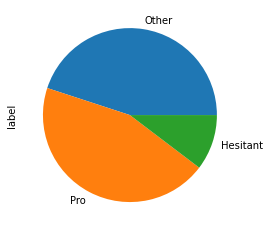

In [14]:
# First we select all the original tweets that received a manual label 
# Note that some tweets may not be present, because despite being a very retweeted content, 
# the original post may not be in the dataset or be in another period
annotated_tweets = tweet[(tweet.id_str.isin(manually_annotated_tweets.index))] 
annotated_tweets["label"] = annotated_tweets.id_str.apply(lambda x : manually_annotated_tweets.loc[x,"label"])

# Second, we select all retweets
RTs = tweet[tweet.RT_id_str.notna()]
annotated_RT = RTs[RTs.RT_id_str.astype(int).isin(manually_annotated_tweets.index)]
annotated_RT["label"] = annotated_RT.RT_id_str.apply(lambda x : manually_annotated_tweets.loc[x,"label"])

# Now concatenate the original tweets and the RT
annotated_tweets = pd.concat([annotated_tweets,annotated_RT])
annotated_tweets.drop_duplicates(inplace=True)
ax = annotated_tweets.label.value_counts().plot.pie()

Labelling the most popular tweets coverage is very high.

In [13]:
print("How many tweets we labeled?",annotated_tweets.id_str.unique().shape[0]/tweet.id_str.unique().shape[0]*100,"%")
print("How many users have retweeted a labeled tweet at least once?",annotated_tweets.user_id_str.unique().shape[0]/len(all_nodes)*100,"%")

How many tweets we labeled? 2.985739495942296 %
How many users have retweeted a labeled tweet at least once? 35.94846548654028 %


## Steps for assigning vaccination leaning scores

1. Perturb network (giving importance to edges' weight)
2. Identify communities (negative eigenvalues)
3. Use labeled tweets to assign labels to users using this clustering
 

### 1.  Perturb the network

In [15]:
n_edges = edges.weight.sum()

# Rewrite the edgelist repeating n entry from source to target with weight=1 
# when source has an edge to target with weight=n
edgelist = pd.DataFrame({col: np.repeat(edges[col], edges["weight"]) for col in ["source","target"]}).reset_index(drop=True)    

# Reshuffle 15% of edges
reshuffled_edges = np.random.randint(0,n_edges,size=(int(0.15*n_edges),2))
# first column represent the link which will be reshuffled
# second columnn represent the new target 
edgelist.loc[reshuffled_edges[:,0],"target"] = edgelist.loc[reshuffled_edges[:,1],"target"].to_list()

# Count how many links there are from source to target (new weight)
edgelist["weight"]=1
edgelist=edgelist.groupby(["source","target"])["weight"].sum().reset_index()

# Select the new wcc
edgelist = weakly_connected_component(edgelist, print_shape=False)
edgelist = edgelist.query("source!=target").reset_index(drop=True) #remove self-loops

### 2. Identify communities

Citations: 
- Dall’Amico, Lorenzo, Romain Couillet, and Nicolas Tremblay. "Nishimori meets Bethe: a spectral method for node classification in sparse weighted graphs." Journal of Statistical Mechanics: Theory and Experiment 2021.9 (2021): 093405.
- Dall'Amico, Lorenzo, Romain Couillet, and Nicolas Tremblay. "A unified framework for spectral clustering in sparse graphs." The Journal of Machine Learning Research 22.1 (2021): 9859-9914.

In order to identify communities, we use the Spectral Clustering (SC) algorithm that coinsists of 3 steps: 
1. Calculate the Laplacian $L$ of the symmetrized adjacency matrix (by the function `SC_laplacian`)
2. Embed the network from $n x n$ matrix to X $n x k$ through k eigenvectors associated with the k smallest eigenvalues of L where k is the number of communities we want to find (by the function `SC`)
3. Find communities by applying k-means to X 

Note: SC is one of the few known methods to estimate the number of communities in graphs, that is k equal to the number of negative eigenvalues of L. We select 15 communities.

In [16]:
from scipy.sparse import eye,bmat
def SC_laplacian(edges,all_nodes=[],return_x=False):
    
    """
    Return Laplacian and weighted adjacency list (not symmetrized)
    """
    
    if len(all_nodes)==0:
        all_nodes = pd.concat([edges.source, edges.target]).unique()

    n = len(all_nodes)
    
    
    mapping = dict(zip(all_nodes, np.arange(n)))
    idx1 = [mapping[e] for e in edges.source]
    idx2 = [mapping[e] for e in edges.target]
    #A == unweighted adjacency matrix
    A = csr_matrix((np.ones(len(idx1)), (idx1, idx2)), shape = (n,n))
    #we symmetrize it
    A = ((A+A.T)>0).astype(int)
    
    #W == weighted adjacency matrix
    W = csr_matrix((edges.weight, (idx1, idx2)), shape = (n,n))
   
    weighted_A = (W + W.T)/2
    idx1,idx2= weighted_A.nonzero()

    d = A@np.ones(n) #degree vector not weighted

    weights = weighted_A[idx1,idx2]
    weights = weights/np.sqrt(np.var(weights))
    w = np.tanh(np.array(weights)[0])
    
    I = eye(n)
    D = diags(d)
    Z = diags(np.ones(n))

    Bp = bmat([[A, I - D], [I, Z]])
    cphi,_ = eigs(Bp, k = 1, which = 'LR')
    cphi=cphi.real
    x = np.sqrt(cphi*np.mean(w**2))
    
    w_el_adj = x*w/(x**2 - w**2)
    w_el_diag = w**2/(x**2 - w**2)

    Omega = csr_matrix((w_el_adj, (idx1, idx2)), shape = (n,n))
    

    Apiuomeno = csr_matrix((w_el_diag, (idx1, idx2)), shape = (n,n))

    dpiuomeno = Apiuomeno@np.ones(n)
    Lambda = diags((dpiuomeno + 1)**(-0.5))
    L = eye(n) - Lambda.dot(Omega.dot(Lambda))

    return L, W, all_nodes

def SC(L, k):
    
    lamb, U = eigsh(L, k = k, which = 'SA') # O(nk**2)
    U = U.real
    for i in range(U.shape[0]):
        U[i] /= np.linalg.norm(U[i])
  
    return U, lamb

In [17]:
# 1
L,W,nodes= SC_laplacian(edgelist) #Laplacian and weighted adjacency list (not symmetrized)
lamb= eigsh(L, k = 15, which = 'SA')[0].real # Top 15 lowest Eigenvalues
k=min([15,sum(lamb<0)]) 
print("k =",k)

# 2
XSC, _ = SC(L, k) # Embedding of nodes in k dimensions

# 3
kmeans = KMeans(n_clusters = k).fit(XSC) # Community detection
labelSC = pd.Series(dict(zip(nodes,kmeans.labels_)))

labelSC.value_counts()    

k = 13


3     1279
5     1182
8     1004
0      970
2      870
12     850
9      590
10     556
4      545
6      495
1      476
7      335
11     318
dtype: int64

Enrich the graph with metadata

In [18]:
G = nx.from_pandas_edgelist(edges, edge_attr=True)

In [19]:
nodes_meta = pd.read_csv(folder+"BE_nl_fr_de_period4_RT_nodes.csv.gz",index_col="Id")
nx.set_node_attributes(G,nodes_meta.to_dict(orient="index"))

In [20]:
import forceatlas2 

# # Create a ForceAtlas2 instance
# forceatlas2 = orceAtlas2()

# Generate the ForceAtlas2 layout
positions = forceatlas2.forceatlas2_networkx_layout(G,niter=100)

# Draw the graph
plt.figure(figsize=(10, 5))
nx.draw_networkx(G, pos=positions, with_labels=False, node_color=[labelSC[node] if node in labelSC else None for node in G.nodes], edge_color='gray',node_size=2,cmap="tab20",width=0.1)
plt.title("ForceAtlas2 Layout")
plt.axis('off')
plt.show()

No cython detected.  Install cython and compile the fa2util module for a 10-100x speed boost.


AttributeError: module 'networkx' has no attribute 'to_numpy_matrix'

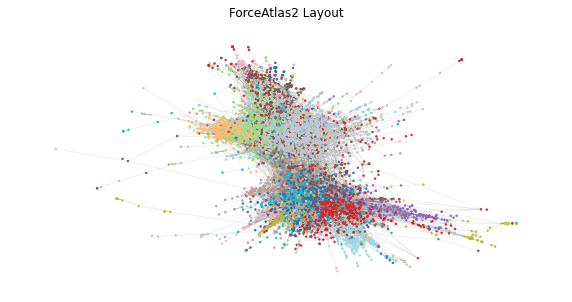

### 3. Use labeled tweets to assign labels to users using this clustering

In [21]:
comm_score={}

for comm in labelSC.unique():
    nodes=labelSC[labelSC==comm].index
    tweet_in_comm=annotated_tweets.query("user_id_str in @nodes")
    count=tweet_in_comm.label.value_counts()
    N_PRO,N_ANTI,N_OTHER=(0,0,0)
    if "Pro" in count:
        N_PRO=count["Pro"]
    if "Hesitant" in count:
        N_ANTI=count["Hesitant"]
    if "Other" in count:
        N_OTHER=count["Other"]

    gamma=((N_ANTI-N_PRO)/(N_ANTI+N_PRO+N_OTHER)+1)/2
    comm_score[comm]=gamma

user_scores=labelSC.map(comm_score)

<Axes: ylabel='Frequency'>

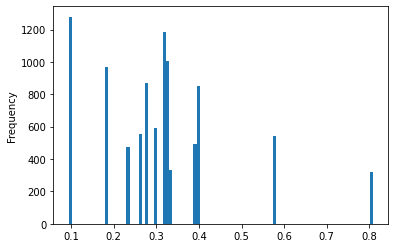

In [22]:
user_scores.plot.hist(bins=100)

# Vaccine leaning score assignment

Now that we have all the pieces is very simple: We repeat for 100 times these 3 steps, then the VHE score of each user will be given by the average of the 100 values assigned to them. It runs for about 10 minutes.

In [23]:
from collections import defaultdict
from scipy.sparse.linalg import ArpackNoConvergence
user_scores={}
user_pet_score={}

n_edges=edges.weight.sum()
neg_eigenvalues=[]
communities=[]
counter=defaultdict(dict)
for run in trange(100): 

    # step 1
    
    edgelist=pd.DataFrame({col: np.repeat(edges[col], edges["weight"]) for col in ["source","target"]}).reset_index(drop=True)    
    
    reshuffled_edges=np.random.randint(0,n_edges,size=(int(0.15*n_edges),2))# first column represent the link which will be reshuffled
                                                                       # second columnn represent the new target 

    edgelist.loc[reshuffled_edges[:,0],"target"]=edgelist.loc[reshuffled_edges[:,1],"target"].to_list()

    edgelist["weight"]=1
    edgelist=edgelist.groupby(["source","target"])["weight"].sum().reset_index()

    edgelist=weakly_connected_component(edgelist,print_shape=False)
    edgelist=edgelist.query("source!=target").reset_index(drop=True)#remove self-loops



    #step 2: Community Detection

    L,W,nodes= SC_laplacian(edgelist) #Laplacian and  weighted adjacency list (not symmetrized)
    while True:
        try:
            lamb= eigsh(L, k = 20, which = 'SA')[0].real
            break
        except:
            pass
        
            
            

    k=min([15,sum(lamb<0)]) #At most I accept 15 communities, so looking for more means splitting a hair in 4
    neg_eigenvalues.append(k)
    while True:
        try:
            XSC, _ = SC(L, k)
            break
        except:
            pass
    
    # Step 3
    kmeans = KMeans(n_clusters = k).fit(XSC)
    labelSC = pd.Series(dict(zip(nodes,kmeans.labels_)))
    
    comm_score={}
    comm_pet_score={}
    for comm in labelSC.unique():
        nodes=labelSC[labelSC==comm].index
        tweet_in_comm=annotated_tweets.query("user_id_str in @nodes")
        count=tweet_in_comm.label.value_counts()
        N_PRO,N_ANTI,N_OTHER,N_PET=(0,0,0,0)
        if "Pro" in count:
            N_PRO=count["Pro"]
        if "Hesitant" in count:
            N_ANTI=count["Hesitant"]
        if "Other" in count:
            N_OTHER=count["Other"]



        gamma=((N_ANTI-N_PRO)/(N_ANTI+N_PRO+N_OTHER)+1)/2
        comm_score[comm]=gamma
        
        counter[run][comm]=count
    user_scores[run]=labelSC.map(comm_score)
    communities.append(labelSC)



  0%|          | 0/100 [00:00<?, ?it/s]

<Axes: ylabel='Frequency'>

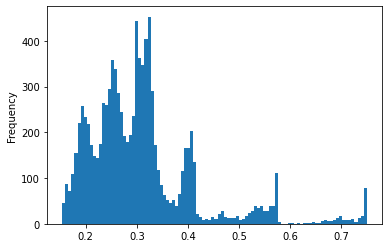

In [24]:
VHE_Score=pd.DataFrame(user_scores).mean(axis=1)
VHE_Score.plot.hist(bins=100)

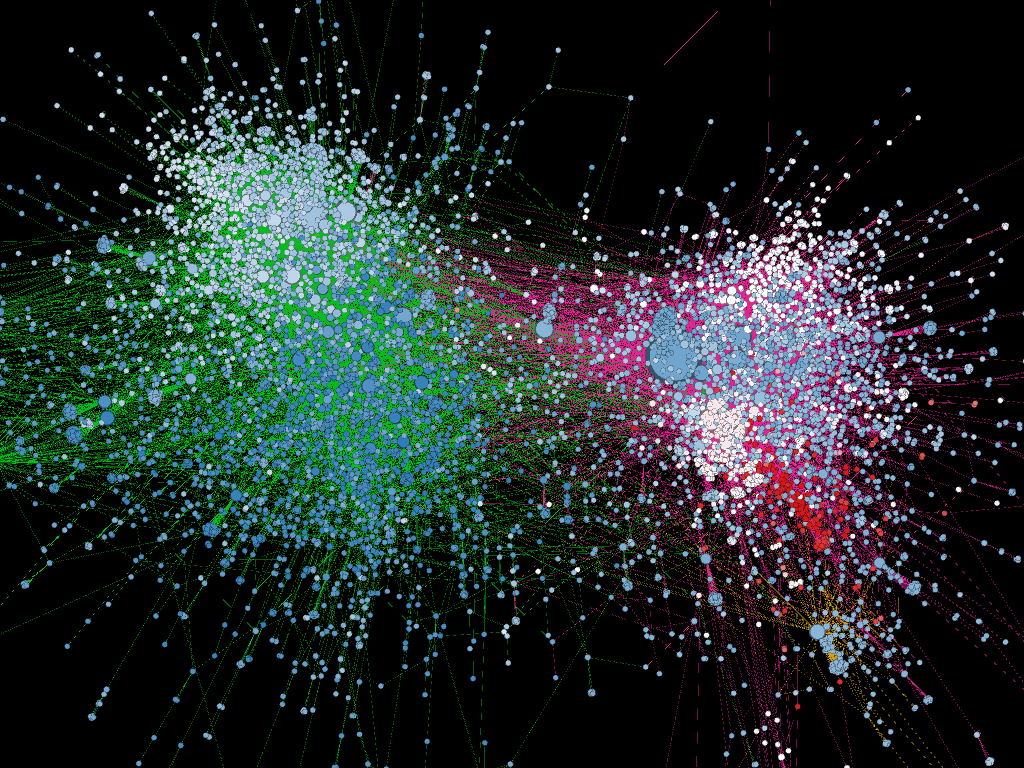

Visualization produced using Gephi

What insights can we gather from this visualization? The edges are colored based on the language of the retweets. As we can observe, users tend to split into two groups: France Twitterers (pink) and Dutch Twitterers (green). On the other hand, the nodes are colored according to their VHE score (Blue=low, Red=High).

This is a perfect example of the limitations of binary graph partitioning algorithms. When the most significant division does not align with the pro and anti-vaccination groups, we lose valuable information.